# Running the model

Setup a `feisty` integration.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

import feisty

## Configure testcase to run

In [3]:
def _comparison(xr_matlab_vals, xr_py_vals, row_name, full_table, seps, thres):
    nstep = np.min([len(xr_matlab_vals["time"].data), len(xr_py_vals["time"].data)])
    nx = np.min([len(xr_matlab_vals["X"].data), len(xr_py_vals["X"].data)])
    matlab_vals = xr_matlab_vals.isel(time=slice(0, nstep), X=slice(0, nx)).data
    py_vals = xr_py_vals.isel(time=slice(0, nstep), X=slice(0, nx)).data
    if thres:
        thres_mask = np.logical_and(np.abs(py_vals) > thres, np.abs(matlab_vals) > thres)
        py_vals = np.where(thres_mask, py_vals, 0)
        matlab_vals = np.where(thres_mask, matlab_vals, 0)
    rel_err_denom = np.where(
        matlab_vals != 0, matlab_vals, 1
    )  # avoid dividing by 0 in next np.where() statement
    if np.any(np.isnan(py_vals)):
        print(f"python has nans for {rowname}!")
        return
    rel_errs = np.where(matlab_vals != 0, np.abs((py_vals - matlab_vals) / rel_err_denom), np.nan)
    rel_errs = np.where(np.logical_and(np.isnan(rel_errs), py_vals == 0), 0, rel_errs)
    rel_errs = np.where(np.logical_and(np.isnan(rel_errs), py_vals > 0), np.inf, rel_errs)
    rel_errs = np.where(np.logical_and(np.isnan(rel_errs), py_vals < 0), -np.inf, rel_errs)

    if full_table or rel_err > 1e-12:
        max_inds = np.nonzero(np.abs(rel_errs) == np.max(np.abs(rel_errs)))
        t_ind = max_inds[0][0]
        x_ind = max_inds[1][0]
        matlab_val = matlab_vals[t_ind][x_ind]
        py_val = py_vals[t_ind][x_ind]
        rel_err = rel_errs[t_ind][x_ind]
        t_val = xr_py_vals.isel(time=t_ind).time.data
        x_val = xr_py_vals.isel(X=x_ind).X.data
        print(
            f"{seps[0]}{row_name} (t={t_val}, X={x_val}){seps[1]}{matlab_val:10.4e}{seps[2]}"
            + f"{py_val:10.4e}{seps[2]}{rel_err:10.4e}{seps[-1]}"
        )


def compare_nc(baseline_ds, test_da_or_ds, full_table=True, markdown_formatting="true", thres=None):
    if type(test_da_or_ds) == xr.Dataset:
        ds = test_da_or_ds
        da = None
        baseline_da = None
        table_header = ''
    else:
        da = test_da_or_ds
        ds = None
        da_dims = ["group", "fish"]
        da_dim = ''
        for dad in da_dims:
            if dad in da.dims:
                da_dim = dad
                break
        baseline_da = baseline_ds[da.name]
        table_header = da_dim
    if markdown_formatting:
        print(f"| {table_header} | Matlab Value | Python Value | Rel Err |")
        print("| --- | --- | --- | --- |")
        seps = ["| ", " | ", " | ", " |"]
    else:
        seps = ["", ": ", ", ", ""]
    if da is not None:
        for n, dimname in enumerate(da[da_dim]):
            _comparison(
                baseline_da.isel({da_dim: n}),
                da.isel({da_dim: n}),
                dimname.data,
                full_table,
                seps,
                thres,
            )
    else:
        for varname in ds:
            _comparison(
                baseline_ds.isel(zooplankton=0)[varname],
                ds.isel(zooplankton=0)[varname],
                varname,
                full_table,
                seps,
                thres,
            )

In [4]:
# Configuration settings for the offline driver as well as output generated in this notebook

driver_config = dict()
# default settings
for matlab_script in ['test_case', 'test_locs3', 'FOSI_cesm', 'FOSI_cesm_daily', 'FOSI_spinup']:
    driver_config[matlab_script] = dict()

    # Baseline file
    driver_config[matlab_script]['baseline'] = f'{matlab_script}.nc'
    driver_config[matlab_script]['baseline_compare'] = True

    # Generate table to compare forcing to matlab
    driver_config[matlab_script]['compare_forcing'] = True

    # When computing table to compare forcing to matlab, replace negative values of poc_flux_bottom, zooC, and zooC_mort with 0
    driver_config[matlab_script]['force_nonnegative'] = True

    # Model date at beginning of simulation
    driver_config[matlab_script]['start_date'] = '0001-01-01'

    # Length of run (in years)
    driver_config[matlab_script]['nyears'] = 1

    # Size of each entry in testcase._ds
    driver_config[matlab_script]['max_output_time_dim'] = 365

    # Cycle the forcing (assumes a single year of forcing is provided)
    driver_config[matlab_script]['ignore_year_in_forcing'] = False

    # List of diagnostics to include in output
    driver_config[matlab_script]['diagnostic_names'] = []

    # Dictionary used to verride FEISTY settings from feisty/core/default_settings.yml
    driver_config[matlab_script]['settings_in'] = {}

    # Run cells that generate plots?
    driver_config[matlab_script]['make_plots'] = True
    driver_config[matlab_script]['make_err_plots'] = False

    # Default plot settings
    driver_config[matlab_script]['plot_settings'] = dict()
    # Column to plot output from
    driver_config[matlab_script]['plot_settings']['X'] = 0
    # y limits for biomass plots
    driver_config[matlab_script]['plot_settings']['ylim'] = [5e-7, 50]

# configurations that differ from default
driver_config['test_case']['ignore_year_in_forcing'] = True
driver_config['test_case']['make_err_plots'] = True
driver_config['test_case']['plot_settings']['ylim'] = [1e-6, 1]

driver_config['test_locs3']['ignore_year_in_forcing'] = True
driver_config['test_locs3']['nyears'] = 2
driver_config['test_locs3']['max_output_time_dim'] = 730
driver_config['test_locs3']['make_err_plots'] = True
driver_config['test_locs3']['plot_settings']['ylim'] = [1e-6, 100]

driver_config['FOSI_spinup']['ignore_year_in_forcing'] = True
driver_config['FOSI_spinup']['nyears'] = 100
for matlab_script in ['FOSI_cesm', 'FOSI_cesm_daily', 'FOSI_spinup']:
    driver_config[matlab_script]['baseline'] = 'FOSI_cesm.nc'
    driver_config[matlab_script]['baseline_compare'] = False
    if matlab_script != 'FOSI_spinup':
        driver_config[matlab_script]['start_date'] = '0249-01-01'
        driver_config[matlab_script]['make_err_plots'] = True
    driver_config[matlab_script]['compare_forcing'] = False
    # diagnostic_names=driver_config[matlab_script]['diagnostic_names'] = ['growth_rate']
    driver_config[matlab_script]['plot_settings']['X'] = 55000  # looks good
    # driver_config[matlab_script]['plot_settings']['X'] = 15633  # large error in small classes
    # driver_config[matlab_script]['plot_settings']['X'] = 11677  # large error in medium classes
    # driver_config[matlab_script]['plot_settings']['X'] = 55000  76989  # large error in benthic

for matlab_script in ['test_case', 'test_locs3']:
    driver_config[matlab_script]['settings_in']['benthic_prey'] = {
        'defaults': {'benthic_efficiency': 0.075, 'carrying_capacity': 0},
        'members': [{'name': 'benthic_prey'}],
    }
    driver_config[matlab_script]['settings_in']['food_web'] = [
        {'predator': 'Sf', 'prey': 'Zoo', 'preference': 1.0},
        {'predator': 'Sp', 'prey': 'Zoo', 'preference': 1.0},
        {'predator': 'Sd', 'prey': 'Zoo', 'preference': 1.0},
        {'predator': 'Mf', 'prey': 'Zoo', 'preference': 0.45},
        {'predator': 'Mf', 'prey': 'Sf', 'preference': 1.0},
        {'predator': 'Mf', 'prey': 'Sp', 'preference': 1.0},
        {'predator': 'Mf', 'prey': 'Sd', 'preference': 1.0},
        {'predator': 'Mp', 'prey': 'Zoo', 'preference': 0.45},
        {'predator': 'Mp', 'prey': 'Sf', 'preference': 1.0},
        {'predator': 'Mp', 'prey': 'Sp', 'preference': 1.0},
        {'predator': 'Mp', 'prey': 'Sd', 'preference': 1.0},
        {'predator': 'Md', 'prey': 'benthic_prey', 'preference': 1.0},
        {'predator': 'Lp', 'prey': 'Mf', 'preference': 0.5},
        {'predator': 'Lp', 'prey': 'Mp', 'preference': 1.0},
        {'predator': 'Lp', 'prey': 'Md', 'preference': 1.0},
        {'predator': 'Ld', 'prey': 'Mf', 'preference': 0.375},
        {'predator': 'Ld', 'prey': 'Mp', 'preference': 0.75},
        {'predator': 'Ld', 'prey': 'Md', 'preference': 1.0},
        {'predator': 'Ld', 'prey': 'benthic_prey', 'preference': 1.0},
    ]

In [5]:
# matlab_script = 'test_case'
matlab_script = 'test_locs3'
# matlab_script = 'FOSI_cesm'
# matlab_script = 'FOSI_spinup'

baselines_from_nc = xr.open_dataset(
    f'../matlab_baselines/{driver_config[matlab_script]["baseline"]}'
)

if matlab_script not in driver_config:
    raise ValueError(f"unknown matlab_script '{matlab_script}'")

if matlab_script == 'test_case':
    testcase = feisty.config_testcase(
        'tanh_shelf',
        'cyclic',
        settings_in=driver_config[matlab_script]['settings_in'],
        max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
    )
else:
    testcase = feisty.config_from_netcdf(
        './forcing.yaml',
        matlab_script,
        start_date=driver_config[matlab_script]['start_date'],
        ignore_year_in_forcing=driver_config[matlab_script]['ignore_year_in_forcing'],  # True,
        settings_in=driver_config[matlab_script]['settings_in'],
        diagnostic_names=driver_config[matlab_script]['diagnostic_names'],
        max_output_time_dim=driver_config[matlab_script]['max_output_time_dim'],
    )

# Set negative forcing values to zero
if driver_config[matlab_script]['force_nonnegative']:
    for var in ['poc_flux_bottom', 'zooC', 'zoo_mort']:
        baselines_from_nc[var].data = np.where(
            baselines_from_nc[var].data > 0, baselines_from_nc[var].data, 0
        )

In [6]:
if driver_config[matlab_script]['compare_forcing']:
    if testcase.ignore_year:
        new_forcing = testcase.forcing.isel(time=slice(1, -1)).transpose('zooplankton', 'time', 'X')
    else:
        new_forcing = testcase.forcing.transpose('zooplankton', 'time', 'X')
    compare_nc(
        baselines_from_nc,
        new_forcing,
    )

    print(
        f"\nMax diff in depth: {np.max(np.abs(baselines_from_nc['dep'].data - testcase.obj.domain_dict['bathymetry'].data))}"
    )

|  | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| T_pelagic (t=0001-01-01 00:00:00, X=195.5) | 4.7453e+00 | 4.7453e+00 | 0.0000e+00 |
| T_bottom (t=0001-01-01 00:00:00, X=195.5) | 4.7647e+00 | 4.7647e+00 | 0.0000e+00 |
| poc_flux_bottom (t=0001-01-01 00:00:00, X=195.5) | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 |
| zooC (t=0001-01-01 00:00:00, X=195.5) | 7.0175e+00 | 7.0175e+00 | 0.0000e+00 |
| zoo_mort (t=0001-01-01 00:00:00, X=195.5) | 5.2470e-02 | 5.2470e-02 | 0.0000e+00 |

Max diff in depth: 0.0


## Run the model


In [7]:
nsteps = driver_config[matlab_script]['nyears'] * 365
%time testcase.run(nsteps)

Calling _solve at 15:57:45
Starting year 1 integration at 15:57:45
Starting year 2 integration at 15:57:54
Finished _solve at 15:58:02
CPU times: user 15.7 s, sys: 13.1 ms, total: 15.7 s
Wall time: 16.8 s


In [8]:
if 'new_ic_file' in driver_config[matlab_script]:
    testcase.create_ic_file_from_final_state(driver_config[matlab_script]['new_ic_file'])

In [9]:
%time testcase.gen_ds()

CPU times: user 400 µs, sys: 17 µs, total: 417 µs
Wall time: 422 µs


In [10]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(baselines_from_nc, testcase.ds["biomass"], nsteps, thres=1e-15)

| group | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| Sf (t=0002-06-20 00:00:00, X=0) | 1.7784e-05 | 1.7784e-05 | 5.7154e-16 |
| Sp (t=0001-01-01 00:00:00, X=0) | 9.9989e-06 | 9.9989e-06 | 0.0000e+00 |
| Sd (t=0002-12-08 00:00:00, X=1) | 8.7526e-06 | 8.7526e-06 | 1.9355e-16 |
| Mf (t=0002-10-05 00:00:00, X=0) | 5.2255e-04 | 5.2255e-04 | 4.1497e-16 |
| Mp (t=0001-01-05 00:00:00, X=2) | 1.5865e-05 | 1.5865e-05 | 2.1356e-16 |
| Md (t=0001-09-16 00:00:00, X=0) | 1.5325e-04 | 1.5325e-04 | 3.5373e-16 |
| Lp (t=0001-07-07 00:00:00, X=2) | 3.0789e-04 | 3.0789e-04 | 3.5214e-16 |
| Ld (t=0001-08-03 00:00:00, X=1) | 2.0739e-05 | 2.0739e-05 | 1.7971e-15 |
| benthic_prey (t=0002-01-06 00:00:00, X=1) | 3.3466e-01 | 3.3466e-01 | 1.9905e-15 |


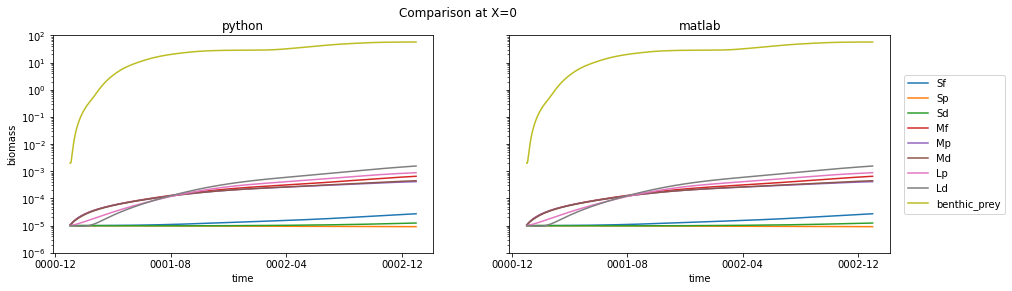

In [11]:
if driver_config[matlab_script]['make_plots']:
    if len(baselines_from_nc.time) > len(testcase.ds.time):
        isel_dict = {"time": range(len(testcase.ds.time))}
        baselines_tmp = baselines_from_nc.isel(isel_dict).assign_coords(
            {'group': testcase.ds.group.data, 'time': testcase.ds.time.data}
        )
    else:
        baselines_tmp = baselines_from_nc.assign_coords({'group': testcase.ds.group.data})
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in testcase.ds.group.data:
        testcase.ds.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[0])
        baselines_tmp.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        ).plot(ax=axs[1])
    for ax in axs:
        ax.set_ylim(driver_config[matlab_script]['plot_settings']['ylim'])
        ax.set_yscale("log")
    axs[0].set_title("python")
    axs[1].set_title("matlab")
    axs[1].set_ylabel("")
    axs[1].set_yticklabels("")
    plt.legend(testcase.ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    fig.suptitle(f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}")

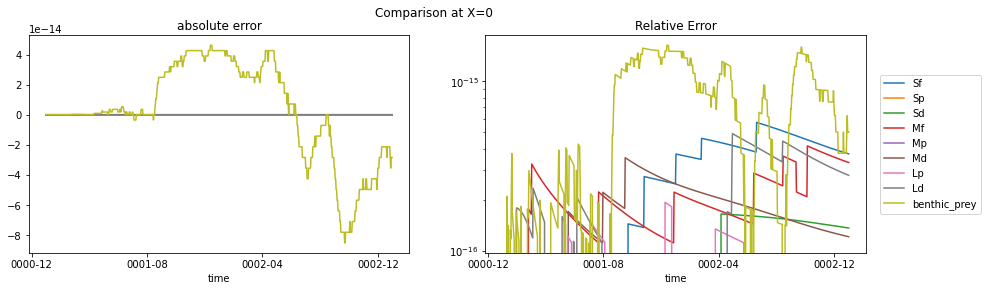

In [12]:
if driver_config[matlab_script]['make_err_plots']:
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for group in testcase.ds.group.data:
        da1 = testcase.ds.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        )
        da2 = baselines_tmp.biomass.sel(group=group).isel(
            X=driver_config[matlab_script]['plot_settings']['X']
        )
        (da1 - da2).plot(ax=axs[0])
        (np.abs(da1 - da2) / da2).plot(ax=axs[1])
    axs[0].set_title("absolute error")
    axs[0].set_ylabel("")
    axs[1].set_title("relative error")
    axs[1].set_ylabel("")
    axs[1].set_yscale("log")
    plt.legend(testcase.ds.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    plt.title("Relative Error")
    fig.suptitle(f"Comparison at X={driver_config[matlab_script]['plot_settings']['X']}")

In [13]:
if driver_config[matlab_script]['baseline_compare']:
    compare_nc(
        baselines_from_nc.isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        testcase.ds["biomass"].isel(X=[driver_config[matlab_script]['plot_settings']['X']]),
        nsteps,
        thres=1e-15,
    )

| group | Matlab Value | Python Value | Rel Err |
| --- | --- | --- | --- |
| Sf (t=0002-06-20 00:00:00, X=0) | 1.7784e-05 | 1.7784e-05 | 5.7154e-16 |
| Sp (t=0001-01-01 00:00:00, X=0) | 9.9989e-06 | 9.9989e-06 | 0.0000e+00 |
| Sd (t=0002-04-06 00:00:00, X=0) | 1.0285e-05 | 1.0285e-05 | 1.6472e-16 |
| Mf (t=0002-10-05 00:00:00, X=0) | 5.2255e-04 | 5.2255e-04 | 4.1497e-16 |
| Mp (t=0001-01-01 00:00:00, X=0) | 1.0541e-05 | 1.0541e-05 | 0.0000e+00 |
| Md (t=0001-09-16 00:00:00, X=0) | 1.5325e-04 | 1.5325e-04 | 3.5373e-16 |
| Lp (t=0001-12-09 00:00:00, X=0) | 2.8092e-04 | 2.8092e-04 | 1.9298e-16 |
| Ld (t=0002-04-30 00:00:00, X=0) | 6.6312e-04 | 6.6312e-04 | 4.9050e-16 |
| benthic_prey (t=0001-12-13 00:00:00, X=0) | 2.8330e+01 | 2.8330e+01 | 1.6302e-15 |
